# 第３章
## MCMCの中をのぞいてみよう
### Opening the Black Box of MCMC
-----
2018/06/04
担当：水谷

-----
　第３章では、第１章と第２章で語られなかったPyMCの中身と、マルコフ連鎖モンテカルロ法(MCMC)について解説する。  
本章を書いた理由は以下の３点である。
* ベイズ推論についてのすべての本がMCMCを扱っている(避けては通れない)
* MCMCのプロセスを知ると、アルゴリズムが収束するかどうかが分かるようになる  
(何に収束するかは後ほど解説する)
* なぜ数千個もの値を事後分布からサンプリングしなければいけないかが理解できるようになる


N個の未知数についてベイズ推論を行うとき、私たちは事前分布が存在するN次元空間を暗黙のうちに作成している。そして、その空間の中に、事前確率を表す「曲面」または「曲線」を考えることができる。空間中のこの曲面は、事前分布によって定義される。例えば２つの未知数p1, p2があるとして、それらの事前分布を一様分布で定義すると、図3.1に示すような平面が事前分布として描画される。

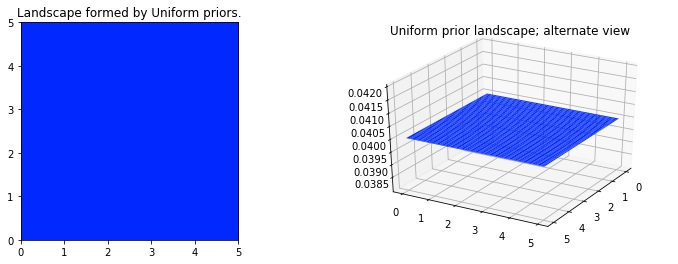

In [6]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");



別の例を考える。  
２つの事前分布をExp(3)とExp(10)にした場合、空間は2次元平面上の全ての正の実数から成り、事前分布を表す曲面は原点(0,0)から正の方向へ下っていく形となる。  
図3.2はこの事前分布を可視化したものであり、色が赤い(薄い)ほどその位置の事前確率が高く、青い(濃い)ほどその位置の事前確率は低いことを表している。

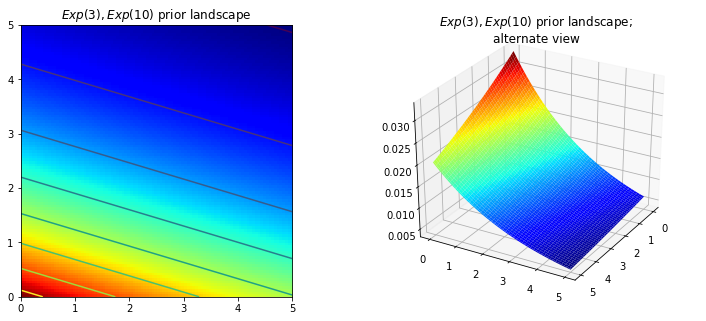

In [7]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");



　これらは単純な2次元空間の例である為、私たちの脳には理解が易しくなっている。
 しかし、実際の問題は、もっと高次元であることに注意しなければいけない。  
　続いて、これらの曲面が未知数についての事前分布を表しているなら、得られた観測データXを取り込んだ「後」には、空間はどうなるだろうか？ということについて考える。
 観測データXは、真のパラメータが存在するであろう場所の情報を反映するように、事前分布（曲面）を変化させる。観測データの数が増すほど、この曲面は複雑な形となる。反対に、観測データの数が少なければ、元々の事前分布の形が比較的保持される。この観測データによって、形が変化した曲面が所謂「事後分布」である。  
　観測データは、事前分布を表す曲面を押し上げたりして、その形を変化させるが、事前確率が低い位置では、押し上げに対する抵抗が大きくなる。先ほどの２つの指数分布が事前分布になる例では、データが(0,0)で観測されたことによってできる山は、(5,5)付近にできる山よりも高くなるだろう。なぜなら、(5,5)付近は抵抗が大きい(事前確率が低い)からである。この山のような地形の事後分布は、真のパラメータがその辺りにある可能性が高いことを示している。なお、事前分布が０となっている場所は、事後分布も０になる。  
 　これより、２つのポワソン分布に対する推論を行うことを考える。この場合、それぞれにパラメータλが存在する。この未知数λを求める問題に対して、事前分布として一様分布と指数分布を用いた場合の結果を比較する。まず、データが一つでだけ与えられた場合の「事前分布」と「事後分布」の例を示す。

In [22]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])



observed (2-dimensional,sample size = 1): [[1 1]]


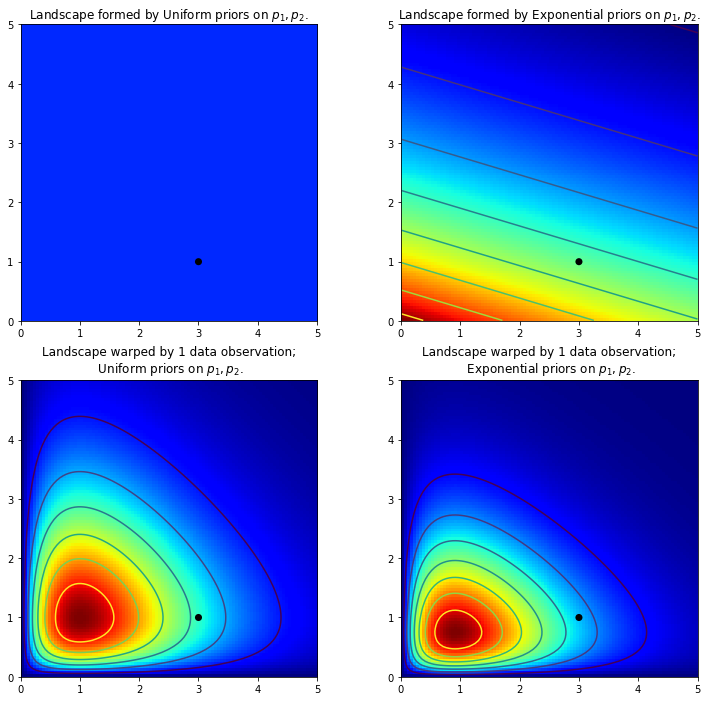

In [23]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);



図3.3中の黒丸が真のパラメータの位置である。左下が左上の一様分布を事前分布として、観測データによって変形された事後分布であり、右下が、右上の指数分布を事前分布として、観測データによって変形された事後分布である。  
観測データはいずれも共通であるが、事後分布の形は異なる。その理由は、指数分布を事前分布とした場合、一様分布に比べて、(5,5)付近の確率は小さくなっている。
そのため、観測データによる変形において、(5,5)付近では押し上げに対する抵抗が大きくなり、その結果、事後分布における形に変化を生じている。  

-----
上記の例で、観測データの数を増やした場合に、事後分布の形状はどうなるか、  
→　事前分布がいずれの場合も、真のパラメータに収束していき、当初のバイアスによる影響度が弱くなっていく。  

------

## 3.1.1 MCMCで地形を探索する
　これから、事後分布の山を求めて、パラメータ空間を探索していくことを考える。しかし、この空間を探索することは容易ではない。N次元空間における探索は、Nが大きくなるほど、空間のサイズが急速に大きくなり、探索が指数的に困難になるからである（次元の呪い）。それでは、複雑な空間で真のパラメータ(書籍には"隠された山々"と記載)を探すには、どうすれば良いか、そこで登場するのが、MCMCという、空間を効率的に探索するアイディアである。ここで探索とは、特定の点を見つけ出すことを意味する。しかし、そのような点がわかりやすいピークであるとは限らない。ものすごくなだらかな山を見つけ出さなければいけない場合もあるからだ。  
 　ここで重要なのは、MCMCが返すのは、事後分布そのものではなく、事後分布から得られる複数のサンプルだということである。先ほど、「MCMCは空間を効率的に探索する」と言ったが、その実際は、現在の周囲を探索して、確率が高い空間に移動していくことである。そして、その周辺をランダムに探索しながら、その付近からのサンプルを返すのである。この一連のサンプルのことを、MCMCやPyMCでは、軌跡(trace)と呼ぶ。  

-----
#### なぜサンプルが数千個も必要か？
　数千個ものデータを、ユーザーに返すのは、事後分布を表現する目的から考えると、非効率的に思われるかもしれない。
しかし、これは、実際には非常に効率的なやり方なのである。試しに別の例で考えてみる。  
1. 「山の範囲」を表す数式を返すとする。すると、N次元空間中の局面が、如何に起伏に富んでいようとも、数式で表さなければいけなくなる。これは容易ではない。
2. 事後分布の山の「頂上」を返すとする。数学的には可能で、合理的でもある(頂上は、未知数の最も確実な推定値に相当する)。しかしこれでは、事後分布の地形の起伏を全て無視してしまうことになる。この情報は、事後分布の確信度を求める上で、重要な情報である。  


以上の２点が、サンプルを返すことの重要性である。また計算量の理由以外に、サンプルを返す利点として「大数の法則」が使えることが挙げられる。これについては、第４章の方で議論する。

# この節のまとめ
　MCMCによって求めたいものは、観測データに関する確率モデルである。上記の例で言いたいのは、少ない観測データからも、観測データに関する確率モデルを推定することは可能であるが、その場合の推定精度は、事前分布の尤もらしさに依存する。逆に観測データが十分多い場合は、事前分布の尤もらしさは、さほど重要ではない。  
 　

# 疑問
上記まとめで言ってることは合っている？